Start with a simple multi-stage classifier.

Use PReLU to make it invertible.

Or LeakyReLU

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import nn
import keras
from keras import layers
from keras.datasets import mnist


In [2]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)



(60000, 784)
(10000, 784)


In [3]:
def create_forward_model():
    sizes = [48, 32, 16]
    kernel_init='he_normal'
    kernel_init='glorot_uniform'
    paper_init=keras.initializers.Constant(0.25)
    input_img = keras.Input(shape=(784,))
    x = layers.Dense(sizes[0], kernel_initializer=kernel_init, name='dense_a')(input_img)
    x = layers.PReLU(alpha_initializer=paper_init, name='prelu_a')(x)
    x = layers.Dense(sizes[1], kernel_initializer=kernel_init, name='dense_b')(x)
    x = layers.PReLU(alpha_initializer=paper_init, name='prelu_b')(x)
    x = layers.Dense(sizes[2], kernel_initializer=kernel_init, name='dense_c')(x)
    x = layers.PReLU(alpha_initializer=paper_init, name='prelu_c')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(num_classes, kernel_initializer=kernel_init, name='dense_output')(x)
    x = layers.Activation("softmax")(x)

    model = keras.Model(input_img, x)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
    model.summary()
    return model


In [4]:
forward_model = create_forward_model()
forward_model.fit(x_train, y_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
          validation_split=0.1)
_, accuracy = forward_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', accuracy)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_a (Dense)             (None, 48)                37680     
                                                                 
 prelu_a (PReLU)             (None, 48)                48        
                                                                 
 dense_b (Dense)             (None, 32)                1568      
                                                                 
 prelu_b (PReLU)             (None, 32)                32        
                                                                 
 dense_c (Dense)             (None, 16)                528       
                                                                 
 prelu_c (PReLU)             (None, 16)                16    

In [5]:
class InvertedDense(layers.Layer):
    def __init__(self, master_layer):
        super(InvertedDense, self).__init__()
        self.master_layer = master_layer

    def build(self, input_shape):
        # do not train weights or bias from master_layer, they are read-only
        self.params = []
        
    def call(self, inputs):  # Defines the computation from inputs to outputs
        W = self.master_layer._trainable_weights[0]
        b = self.master_layer._trainable_weights[1]
        w = tf.transpose(W)
        return tf.matmul(inputs - b, w)
    

In [6]:
class InvertedPReLU(layers.Layer):
    def __init__(self, master_layer):
        super(InvertedPReLU, self).__init__()
        self.master_layer = master_layer

    def build(self, input_shape):
        # do not train weights or bias from master_layer, they are read-only
        self.params = []

    def call(self, inputs):
        alpha = 1/(self.master_layer.alpha + 0.00001)
        pos = keras.backend.relu(inputs)
        neg = -alpha * keras.backend.relu(-inputs)
        return pos + neg


In [7]:
def create_inverted_model(forward_model):
    input_label = keras.Input(shape=(num_classes,))
    forward_layers = {}
    for l in forward_model.layers:
        forward_layers[l.name] = l

    # No need to "invert" softmax, input is in logits format (0,0,1,0,0)
    x = InvertedDense(forward_layers['dense_output'])(input_label)
    x = InvertedPReLU(forward_layers['prelu_c'])(x)
    x = InvertedDense(forward_layers['dense_c'])(x)
    x = InvertedPReLU(forward_layers['prelu_b'])(x)
    x = InvertedDense(forward_layers['dense_b'])(x)
    x = InvertedPReLU(forward_layers['prelu_a'])(x)
    x = InvertedDense(forward_layers['dense_a'])(x)
  
    inverted_model = keras.Model(input_label, x)
    inverted_model.compile(optimizer='adam', loss='mse')
    inverted_model.summary()
    return inverted_model


In [8]:
num_epochs = 300
inverted_model = create_inverted_model(forward_model)

inverted_model.evaluate(y_test, x_test)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 inverted_dense (InvertedDen  (None, 16)               170       
 se)                                                             
                                                                 
 inverted_p_re_lu (InvertedP  (None, 16)               16        
 ReLU)                                                           
                                                                 
 inverted_dense_1 (InvertedD  (None, 32)               528       
 ense)                                                           
                                                                 
 inverted_p_re_lu_1 (Inverte  (None, 32)               32        
 dPReLU)                                                   

750580.25

In [9]:

predicted_imgs = inverted_model.predict(y_test)
print(predicted_imgs.shape)

(10000, 784)


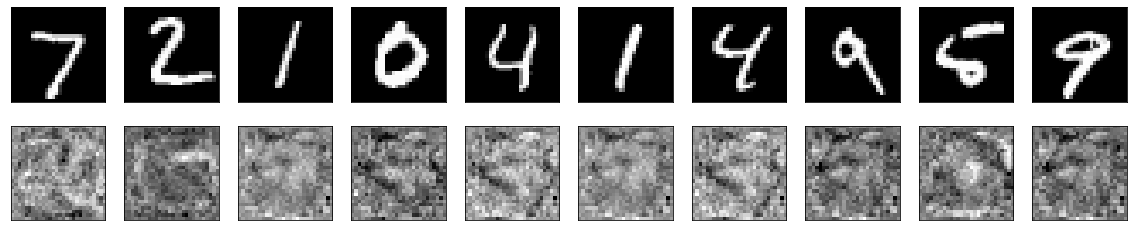

In [10]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predicted_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
